In [55]:
import json
import string
from six.moves import cPickle as pickle
import numpy as np
from scipy.misc import comb
from math import log, exp, sqrt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
# sns.set_context("paper")
# sns.set_context('talk')
%matplotlib inline

In [ ]:
#Load vocab
vocab = []
for line in open('../data/vocab.fr', 'r'):
    vocab.append(line.strip())
    
infos = pickle.load(open('../data/fr_trg.pkl', 'rb'))
itow = infos['itow']#itow[0] = "<PAD>"
#itow[1] = "_EOS"
#itow[2] = "_BOS"
print('0, 1 & 2', itow[0], itow[1], itow[2])
# itow[0] = 'EOS'
print('Itow size:', len(itow))
print('Vocab size:', len(vocab))

In [ ]:
words = list(itow.values())
for w in words:
    if "." in w:
        print(w)

In [ ]:
#Load vocab
vocab_en = []
for line in open('../data/vocab.en', 'r'):
    vocab_en.append(line.strip())
infos_en = pickle.load(open('../data/en_src.pkl', 'rb'))
itow_en = infos_en['itow']
print('0, 1 & 2', itow_en[0], itow_en[1], itow_en[2])
print('Itow size:', len(itow_en))
print('Vocab size:', len(vocab_en))

In [ ]:
for w in vocab:
    if w not in list(itow.values()):
        print('Missing', w)

In [ ]:
for w in vocab_en:
    if w not in list(itow_en.values()):
        print('Missing', w)

In [ ]:
assert len(list(set(vocab).intersection(list(itow.values())))) - len(vocab) == 0
assert len(list(set(vocab_en).intersection(list(itow_en.values())))) - len(vocab_en) == 0

## Stats

In [3]:
infos = pickle.load(open('../data/fr_trg.pkl', 'rb'))
itow = infos['itow']
stats = pickle.load(open('../data/vocab_fr_stats.pkl', 'rb'))
vocab = stats['vocab']
counts = stats['counts']
lengths = stats['lengths']
del stats, infos

In [4]:
cw = {}
for (c, w) in counts:
    cw[w] = c

In [ ]:
sns.set()
f, ax = plt.subplots(1, 1, figsize=(10, 4))
nsents = sum(list(lengths.values()))
plenghts = [l/nsents for k,l in lengths.items()]
ax.bar(list(lengths), plenghts)
ax.set_yticklabels(['{:.0f}\%'.format(x*100) for x in ax.get_yticks()]) 


In [5]:
MATCH = {v: k for k,v in itow.items()}

In [6]:
F = np.ones(len(itow))
missing = []
for ix, w in itow.items():
#     print("ix", ix, type(ix), "w", w)
    if ix < 4:
        continue
    if w in cw:
        F[ix] = cw[w]
    else:
        print('Missing word ', w)
        missing.append(w)

Missing word  tabLog


In [7]:
F = F.reshape(-1, 1)
FF1 = F * (1/F).T
FF2 = 1/F * F.T
FF = np.minimum(FF1, FF2)
del FF1, FF2
pickle.dump(np.float32(FF), open('../data/idf_fr.pkl', 'wb'))

In [16]:
FF = pickle.load(open('../data/idf_fr.pkl', 'rb'))
sim_fr = pickle.load(open('../data/fr_similarities.pkl','rb'))

In [60]:
def normalize(A):
    l1 = A.sum(axis=1)
    A /= l1.reshape(len(A), 1)
    return A

def exps(sim, tau=0.2, freq=False):
    if freq:
        return normalize(np.exp((sim-1 - tau * FF)/tau))
    else:
        return normalize(np.exp((sim-1)/tau))
    
def plot_word_neighbors(ax, selected, sim, prefix, NN=15, verbose=0):
    sns.set()
    h = .04
    colors = sns.color_palette("Paired", NN)
    k = MATCH[selected.decode()]
    nbrs = np.flip(sim[k].argsort()[-NN:][::-1], axis=0)
    wnbrs = [itow[i].encode().decode() for i in nbrs]
    print('neighbotrs', wnbrs)
#     simnbrs = [sim[k,k] - sim[k,i] for i in nbrs]
    simnbrs = [sim[k,i] for i in nbrs]
    ys = 4 / 3 * h * np.arange(NN)
    ax.barh(ys, simnbrs, height=h, align='edge', color="darkgray")
    ax.set_yticks(ys + h/2)
    ax.tick_params('y', labelsize=14)
    ax.set_yticklabels(wnbrs)
    ax.set_ylim(min(ys), max(ys) + h)
    ax.set_title("%s: %s\'s top %d neighbors" % (prefix, itow[k].encode().decode(), NN), fontsize=16)
#     plt.tight_layout()
#         plt.savefig('../figures/%s_nbrs_%s.png' % (prefix, WORDS[k]),
#                     dpi=300, bbox_inches='tight')



neighbotrs ['faune', 'pins', 'forestier', 'montagnes', 'sauvage', 'humide', 'arbres', 'Forêt', 'bois', 'montagne', 'plaine', 'végétation', 'forestière', 'forêts', 'forêt']
neighbotrs ['faune', 'pins', 'forestier', 'montagnes', 'sauvage', 'humide', 'arbres', 'Forêt', 'bois', 'montagne', 'plaine', 'végétation', 'forestière', 'forêts', 'forêt']
neighbotrs ['feuillus', 'zones', 'jungle', 'boréale', 'zone', 'chênes', 'humide', 'forestière', 'bois', 'pins', 'végétation', 'Forêt', 'plaine', 'forêts', 'forêt']


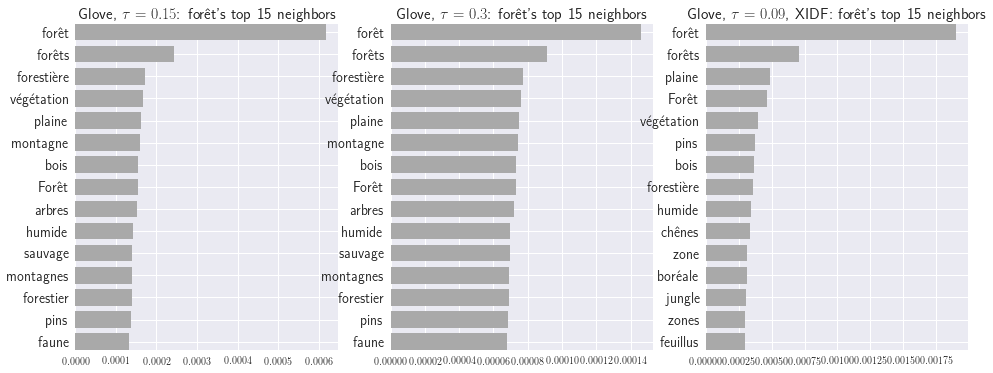

In [66]:
sns.set()
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
# plot_word_neighbors(axs[0], 'forêt'.encode(), sim_fr, 'Glove')
plot_word_neighbors(axs[0], 'forêt'.encode(), exps(sim_fr, 0.15), 'Glove, $\\tau=0.15$')
plot_word_neighbors(axs[1], 'forêt'.encode(), exps(sim_fr, 0.3), 'Glove, $\\tau=0.3$')
plot_word_neighbors(axs[2], 'forêt'.encode(), exps(sim_fr, 0.09, True), 'Glove, $\\tau=0.09$, XIDF')



In [31]:
'forêt'.encode().decode()

'forêt'